<a href="https://colab.research.google.com/github/PGestrich/AML-Time-Series-Forecasting/blob/main/AML_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML Project - Time Series Forecasting

Julian Nürk, 

Prisca Gestrich

## Data Stuff

### 1. Utility / Loading Data

In [74]:
#general
import numpy as np
import pandas as pd
!pip install -q kaggle

#Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from google.colab import files

In [75]:
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'store-sales-time-series-forecasting'
! mkdir data
! unzip store-sales-time-series-forecasting.zip -d data

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘data’: File exists
Archive:  store-sales-time-series-forecasting.zip
replace data/holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [76]:
oil = pd.read_csv('/content/data/oil.csv')
holidays = pd.read_csv('/content/data/holidays_events.csv')
stores = pd.read_csv('/content/data/stores.csv')
train = pd.read_csv('/content/data/train.csv')
transactions = pd.read_csv('/content/data/transactions.csv')
test = pd.read_csv('/content/data/test.csv')



## Process Data

holiday handling:

0: work day

1 - weekend / bridge day

2 - holiday

type additional: ??? 

transferred holidays are considered normal days

only first holiday in holidays is considered




In [77]:
#change dtype of date column to datetime
oil['date'] = oil['date'].apply(pd.to_datetime)
holidays['date'] = holidays['date'].apply(pd.to_datetime)
train['date'] = train['date'].apply(pd.to_datetime)
transactions['date'] = transactions['date'].apply(pd.to_datetime)
test['date'] = test['date'].apply(pd.to_datetime)

In [78]:
#expand oil to include all dates + interpolate missing data
oil = oil.set_index('date').asfreq('D').reset_index()
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate('linear').ffill().bfill()
train = train.merge(oil)
train = train.rename(columns={"dcoilwtico": "oilprice"})


#change family names to numeric values
fam = np.unique(train['family'])
fam_lookup = pd.DataFrame(data = {'family': fam, 'family_id': range(len(fam))})
train  = train.merge(fam_lookup)


#split up date into multiple informations
train['date'] = train['date'].apply(pd.to_datetime)
train['day'] = train['date'].apply(lambda time: time.day)
train['month'] = train['date'].apply(lambda time: time.month)
train['weekday'] = train['date'].apply(lambda time: time.dayofweek)
train['year'] = train['date'].apply(lambda time: time.year)

In [116]:
#create shortened data for test purposes
oil_short = oil.loc[oil['date'] < '2013-02-01']
holidays_short = holidays.loc[holidays['date'].between('2013-01-01', '2013-02-01')]
train_short = train.loc[train['date'] < '2013-02-01']
transactions_short = transactions.loc[transactions['date'] < '2013-02-01']
test_short = test.loc[test['date'] < '2013-02-01']

In [172]:
#holiday handling

def isholiday(row):
  #data
  date = row['date']
  event = holidays.loc[holidays['date'] == date][0:1]
  id = row['store_nbr']
  city = stores.loc[stores['store_nbr'] == id]['city'].values
  state = stores.loc[stores['store_nbr'] == id]['state'].values
  
  
  #check if events apply:
  if len(event) > 0:
    national = event['locale'].values == 'National'
    regional = event['locale'].values == 'Regional' and event['locale_name'].values == state
    local = event['locale'].values == 'Local' and event['locale_name'].values == city
    
    if national[0] or regional[0] or local[0]:
      if event['type'].values == 'Holiday' and  event['transferred'].values == False:
        return 2
      if event['type'].values == 'Bridge':
        return 1
      if event['type'].values == 'Work Day':
        return 0

  #otherwise: check if weekend
  if row['weekday']< 5:
    return 0
  else: 
    return 1


  


print(stores[0:1], '\n')
train_short['holiday'] = 0
train_short['holiday'] = train_short.apply(lambda row: isholiday(row), axis = 1)

train_short

   store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,date,store_nbr,family,sales,onpromotion,oilprice,family_id,day,month,weekday,year,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,2
1,33,2013-01-01,10,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,2
2,66,2013-01-01,11,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,2
3,99,2013-01-01,12,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,2
4,132,2013-01-01,13,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911621,55109,2013-01-31,54,SEAFOOD,3.000,0,97.65,32,31,1,3,2013,0
2911622,55142,2013-01-31,6,SEAFOOD,20.089,0,97.65,32,31,1,3,2013,0
2911623,55175,2013-01-31,7,SEAFOOD,43.647,0,97.65,32,31,1,3,2013,0
2911624,55208,2013-01-31,8,SEAFOOD,42.621,0,97.65,32,31,1,3,2013,0


In [149]:


isholiday(holidays_test[0:1])

2

In [169]:
holidays_short


,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False


In [ ]:
#load shortened data
nrows = 1000
train_short=pd.read_csv('/content/data/train.csv', nrows=nrows)
test_short=pd.read_csv('/content/data/train.csv', nrows=nrows)



In [ ]:
family_num = np.unique(train_short['family'])
family_lookup = dict(zip(family_num, range(len(family_num))))
family_num = [family_lookup.get(item)  for item in family_num]

train_short['family_num'] = family_num
#create mockup data to test if running
X_train = train_short[['id', 'weekday','store_nbr', 'month', 'onpromotion']]
Y_train = train_short[['sales']]


,id,date,store_nbr,family,sales,onpromotion,day,family_num,month,weekday,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,990,1,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,1,991,1,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,1,992,1,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,993,1,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,1,994,1,1,2013


In [ ]:
#create testset only considering automotives at store 1
train_auto = train.copy()
print(train_auto.shape[0])
train_auto = train_auto.loc[train_auto['family'] == "AUTOMOTIVE"]
train_auto = train_auto.loc[train_auto['store_nbr'] == 1]
print(train_auto.shape[0])

train_auto['date'] = train_auto['date'].apply(pd.to_datetime)
train_auto['weekday'] = train_auto['date'].apply(lambda time: time.dayofweek)
train_auto['day'] = train_auto['date'].apply(lambda time: time.day)



X_train = train_auto[['id', 'day', 'weekday', 'onpromotion']]
plot_dates = train_auto[['date']]
Y_train = train_auto[['sales']]


train_auto = test.copy()
print(train_auto.shape[0])
train_auto = train_auto.loc[train_auto['family'] == "AUTOMOTIVE"]
train_auto = train_auto.loc[train_auto['store_nbr'] == 1]
print(train_auto.shape[0])

train_auto['date'] = train_auto['date'].apply(pd.to_datetime)
train_auto['weekday'] = train_auto['date'].apply(lambda time: time.dayofweek)
train_auto['day'] = train_auto['date'].apply(lambda time: time.day)

X_test = train_auto[['id', 'day', 'weekday', 'onpromotion']]

3000888
1684
28512
16


## Models

returns array 'predict' with predictions

### Random Forest Regressor

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=2, random_state=0)

In [ ]:
predict = regr.predict(X_test)

## Plots

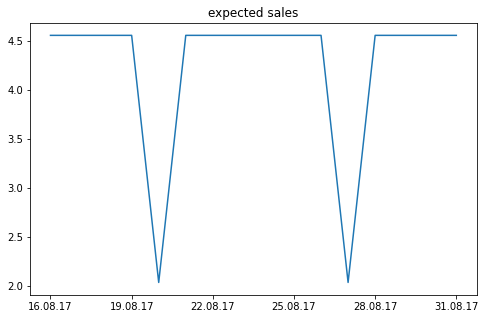

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(8, 5))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(train_auto['date'], predict, label = "prediction")
plt.title('expected sales')
date_form = DateFormatter("%d.%m.%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.show()

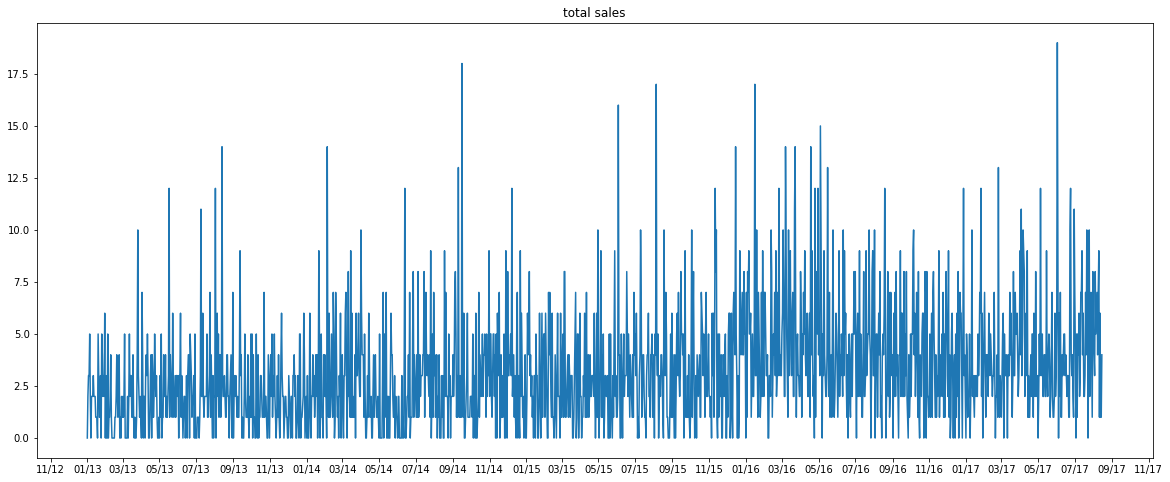

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(plot_dates, Y_train, label = "prediction")
date_form = DateFormatter("%m/%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.title('total sales')
plt.show()

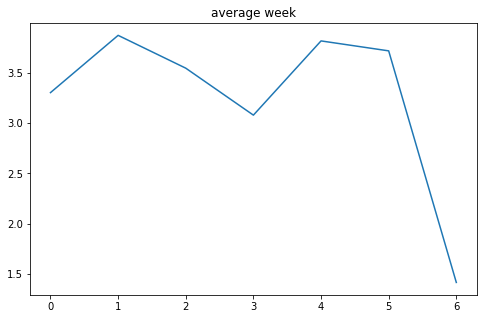

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

days = np.zeros(7)
counter  = np.zeros(7)

dates = plot_dates.copy()
dates['weekday'] = dates['date'].apply(lambda time: time.dayofweek)

wd = dates['weekday'].values.flatten()

sales = Y_train.values.flatten()
for i in range(len(plot_dates)):
  weekday = wd[i]
  days[weekday] += sales[i]
  counter[weekday] += 1

days = days/counter
fig, ax = plt.subplots(figsize=(8, 5))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(days, label = "prediction")
plt.title('average week')
plt.show()

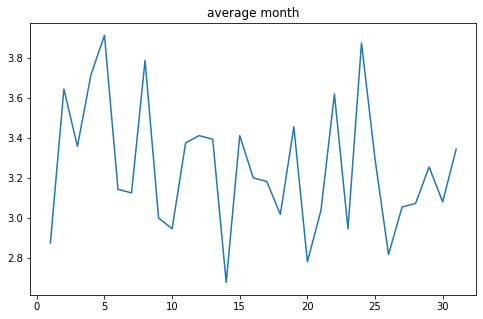

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

days = np.zeros(31)
counter  = np.zeros(31)

dates = plot_dates.copy()
dates['day'] = dates['date'].apply(lambda time: time.day)

wd = dates['day'].values.flatten()

sales = Y_train.values.flatten()
for i in range(len(plot_dates)):
  weekday = wd[i] - 1
  days[weekday] += sales[i]
  counter[weekday] += 1

days = days/counter
fig, ax = plt.subplots(figsize=(8, 5))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(range(1, 32), days, label = "prediction")
plt.title('average month')
plt.show()